## Simple thermal finite element analysis for BLAST CubeSat

This simple first-approximation analysis can give a rough idea about the aggregate thermals of the whole sat. It uses the `BetaCircularOrbit` to assume a constant-beta-angle circular Earth orbit and one `UniformLumpedMass` to represent the entire sat. It does not take into account attitude/rotation/view factors, nor does it resolve the sat into separate components. Getting an idea of seasonal variation requires varying the beta angle with which the orbit is initialized. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.integrate
from typing import Sequence

from constants import *
from orbit import Orbit, BetaCircularOrbit
from lumped_mass import LumpedMass, UniformLumpedMass
from plotting import *

def eval_funct(t, T_vec: np.ndarray, elts: list[LumpedMass], orbit: Orbit) -> np.ndarray:
    """Simple derivative function which calculates Tdot for elts using temperatures from T_vec and orbital state from orbit""" 
    orbit.set_input(t)
    q_solar_normal, q_earth_normal = orbit.get_sun_earth_normal_power()

    for T, elt in zip(T_vec, elts):
        elt.set_input(t, T, q_solar_normal=q_solar_normal, q_earth_normal=q_earth_normal)

    Tdot_vec = np.array([elt.find_Tdot() for elt in elts])

    return Tdot_vec

def propagate_thermal_fem(elts: Sequence[LumpedMass], orbit: Orbit, t_span: tuple[float, float], t_eval: list[float]|None = None, **kwargs):

    res = scipy.integrate.solve_ivp(
        eval_funct, 
        t_span, 
        np.array([elt.T for elt in elts]), 
        t_eval=t_eval, 
        args=(elts, orbit),
        **kwargs
    )

    return res

### Model definition
This simulation defines a single `UniformLumpedMass` to represent the whole sat (which has four long sides fully covered with solar panels, one square side with the UHF antenna (which is basically just a PCB made out of FR4), and one square side which is the GGB tip mass which is aluminum on the outside). It has a mass equal to the total sat mass, a radiative area equal to the total external area of the sat, absorptivity and emissivity as weighted averages over the total external area, and one internal heat source. The constant view factor is set as 1/5 since one long side is 1/5 of the total external area of the sat (treating the GGB face as flat and square). 

The orbit is defined with an altitude of 500 km and an orbital period of 90 minutes (LEO), and a mild beta angle of 60° at first.

In [9]:
def init_spherical_sat(orbit_beta_deg: float) -> tuple[Sequence[LumpedMass], Orbit]:
    elts = [
        UniformLumpedMass(
            m=CUBESAT_MASS, 
            c=AL_6061_SPEC_HEAT_CAP,
            A_rad=CUBESAT_TOTAL_EXT_AREA, 
            a=SOLAR_PANEL_ABSORPTANCE*.8 + AL_ABSORPTANCE*.1 + FR4_ABSORPTANCE*.1,
            e=SOLAR_PANEL_EMISSIVITY*.8 + AL_EMISSIVITY*.1 + FR4_EMISSIVITY*.1,
            q_int=CUBESAT_POWER_CONSUMPTION,
            F=0.2,
            T0=273*u.degK,
            store_history = True
        )
    ]
    orbit = BetaCircularOrbit(500*u.km, 90*u.min, np.radians(orbit_beta_deg))
    return elts, orbit

In [ ]:
elts, orbit = init_spherical_sat(orbit_beta_deg=60)

### Analysis

In [11]:
res = propagate_thermal_fem(
    elts, orbit, (0, 10*90*60),
    atol=0.05, max_step=100
)
print(res)

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.090e+00 ...  5.391e+04  5.400e+04]
        y: [[ 2.730e+02  2.730e+02 ...  2.837e+02  2.838e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3254
     njev: 0
      nlu: 0


(<Axes: xlabel='Time (orbital periods)', ylabel='T (K)'>,
 <Axes: ylabel='Heat flux (W)'>,
  <matplotlib.collections.PathCollection at 0x206f6871310>])

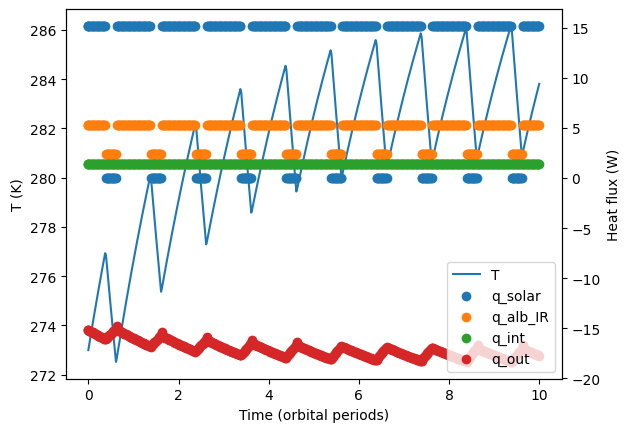

In [12]:
plot_elt_T_q_flows(res.t, res.y[0], elts[0], orbital_period=(90*u.min).to(u.s).magnitude)

Let's try a high beta angle - this means the sat's orbit is face-on to the Sun and thus the sat is in the sun all the time. In LEO at 51 deg inclination, this happens about once a month for a day or so.

  message: The solver successfully reached the end of the integration interval.
  success: True
   status: 0
        t: [ 0.000e+00  1.090e+00 ...  5.391e+04  5.400e+04]
        y: [[ 2.730e+02  2.730e+02 ...  2.991e+02  2.991e+02]]
      sol: None
 t_events: None
 y_events: None
     nfev: 3254
     njev: 0
      nlu: 0


(<Axes: xlabel='Time (orbital periods)', ylabel='T (K)'>,
 <Axes: ylabel='Heat flux (W)'>,
  <matplotlib.collections.PathCollection at 0x206f8cf0550>])

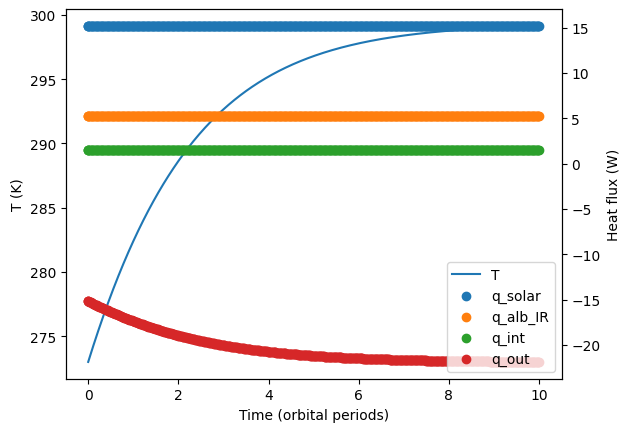

In [13]:
elts, orbit = init_spherical_sat(orbit_beta_deg=80)
res = propagate_thermal_fem(
    elts, orbit, (0, 10*90*60),
    atol=0.05, max_step=100
)
print(res)
plot_elt_T_q_flows(res.t, res.y[0], elts[0], orbital_period=(90*u.min).to(u.s).magnitude)